Example of how to plot the average temperature above 1km depth using mask around Antarctica using experiment from 01deg_jra55v13_ryf9091.

In [1]:
%matplotlib inline

# Standard modules
import cosima_cookbook as cc
from dask.distributed import Client
import numpy as np
import xarray as xr
import netCDF4 as nc

# For plotting
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.patches as patches
import cmocean as cm

#From file of "Age at the Bottom of the Ocean"
from collections import OrderedDict
import cftime
import glob

#From file of "Cross-slope section"
# For gradient calculation (We will need the topographic gradient to calculate the along-slope velocity component)
import xgcm
# Load metpy module to obtain cross section (Select the conda/analusis3-unstable kernel if you have problems loading this module)
from metpy.interpolate import cross_section

#From file of "barotropic streamfunction"
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning) 

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

In [2]:
client = Client(n_workers=4)

# Load database
session = cc.database.create_session()

In [4]:
# Latitude range (pan-Antarctic)
lat_min = -90
lat_max = -60

# Import variables from experiments, convert temperature to degree Celsius
salt = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='salt', 
                          session=session, frequency='1 monthly',
                          start_time='1999-12-31 00:00:00', 
                          end_time='2039-12-31 00:00:00')
ht = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='ht', 
                          session=session, frequency='static', n=1)

# Select latitude range:
salt = salt.sel(yt_ocean = slice(lat_min, lat_max))
ht = ht.sel(yt_ocean = slice(lat_min, lat_max))

# annual_average 
salt = salt.groupby('time.year').mean(dim='time')

# Select surface ocean:
salt_surface = salt.sel(st_ocean=0, method='nearest')
# Select slice at 250 m depth:
salt_250m = salt.sel(st_ocean=250, method='nearest')
# Weighted average salt with all depths
weights_st = salt.st_ocean
salt_st = salt.weighted(weights_st).mean('st_ocean')

Now, make a `land_mask`. This is just a dataarray with `1`'s where you have ocean and `0`'s where you have land. We are going to work with this mask to delineate the different ocean basins.

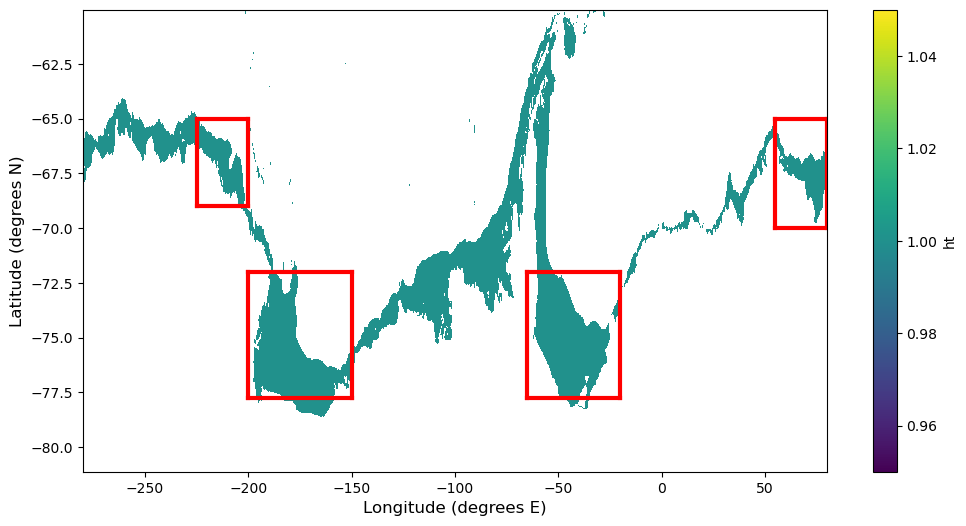

In [5]:
land_mask = ~ht.isnull()
shelf_mask = (land_mask.where(ht < 1000))

fig=plt.figure(2,(12,6))
ax = plt.subplot()
shelf_mask.plot()
plt.xlabel('Longitude (degrees E)', fontsize=12)
plt.ylabel('Latitude (degrees N)', fontsize=12)

#Put salt into the shelf mask
salt_shelf = salt*shelf_mask
salt_st_shelf = salt_st*shelf_mask
salt_surface_shelf = salt_surface*shelf_mask
salt_250m_shelf = salt_250m*shelf_mask

#Weighted average salt with lon-lat
weights = np.cos(np.deg2rad(salt.yt_ocean))

salt_st_shelf_weighted = salt_st_shelf.weighted(weights)
salt_surface_shelf_weighted = salt_surface_shelf.weighted(weights)
salt_250m_shelf_weighted = salt_250m_shelf.weighted(weights)

#Weddell
bottomleft_lon=-65
bottomleft_lat=-77.75
topright_lon=-20
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

salt_shelf_Weddell = salt_shelf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_Weddell_weighted = salt_shelf_Weddell.weighted(weights_st).mean('st_ocean')
salt_st_shelf_Weddell = salt_st_shelf_Weddell_weighted.weighted(weights)
salt_surface_shelf_Weddell = salt_shelf_Weddell.sel(st_ocean=0, method='nearest').weighted(weights)
salt_250m_shelf_Weddell = salt_shelf_Weddell.sel(st_ocean=250, method='nearest').weighted(weights)

#Ross
bottomleft_lon=-200
bottomleft_lat=-77.75
topright_lon=-150
topright_lat=-72

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

salt_shelf_Ross = salt_shelf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_Ross_weighted = salt_shelf_Ross.weighted(weights_st).mean('st_ocean')
salt_st_shelf_Ross = salt_st_shelf_Ross_weighted.weighted(weights)
salt_surface_shelf_Ross = salt_shelf_Ross.sel(st_ocean=0, method='nearest').weighted(weights)
salt_250m_shelf_Ross = salt_shelf_Ross.sel(st_ocean=250, method='nearest').weighted(weights)

#CapeD
bottomleft_lon=55
bottomleft_lat=-70
topright_lon=80
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

salt_shelf_CapeD = salt_shelf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_CapeD_weighted = salt_shelf_CapeD.weighted(weights_st).mean('st_ocean')
salt_st_shelf_CapeD = salt_st_shelf_CapeD_weighted.weighted(weights)
salt_surface_shelf_CapeD = salt_shelf_CapeD.sel(st_ocean=0, method='nearest').weighted(weights)
salt_250m_shelf_CapeD = salt_shelf_CapeD.sel(st_ocean=250, method='nearest').weighted(weights)

#Mertz
bottomleft_lon=-225
bottomleft_lat=-69
topright_lon=-200
topright_lat=-65

ax.plot([bottomleft_lon,topright_lon], [bottomleft_lat,bottomleft_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,topright_lon], [topright_lat,topright_lat], 'r', linewidth = 3)
ax.plot([bottomleft_lon,bottomleft_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)
ax.plot([topright_lon,topright_lon], [bottomleft_lat,topright_lat], 'r', linewidth = 3)

salt_shelf_Mertz = salt_shelf.sel(xt_ocean=slice(bottomleft_lon,topright_lon),yt_ocean=slice(bottomleft_lat,topright_lat))
#weighted averages
salt_st_shelf_Mertz_weighted = salt_shelf_Mertz.weighted(weights_st).mean('st_ocean')
salt_st_shelf_Mertz = salt_st_shelf_Mertz_weighted.weighted(weights)
salt_surface_shelf_Mertz = salt_shelf_Mertz.sel(st_ocean=0, method='nearest').weighted(weights)
salt_250m_shelf_Mertz = salt_shelf_Mertz.sel(st_ocean=250, method='nearest').weighted(weights)

KeyboardInterrupt: 

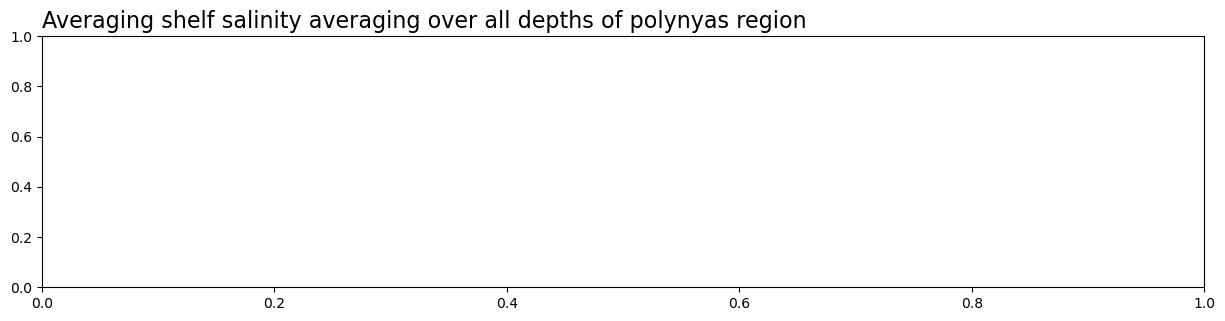

In [36]:
fig = plt.figure(figsize=(15, 15))

#Plotting mean shelf salinity at surface, 250m and averaging over all depths
plt.subplot(4,1,1)
plt.title('Averaging shelf salinity averaging over all depths of polynyas region', fontsize=16, loc='left')
salt_st_shelf_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='Weddell')
salt_st_shelf_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='Ross')
salt_st_shelf_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='CapeD')
salt_st_shelf_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

plt.subplot(4,1,2)
plt.title('Averaging shelf salinity at surface of polynyas region', fontsize=16, loc='left')
salt_surface_shelf_Weddell.mean(("xt_ocean", "yt_ocean")).plot(label='Weddell')
salt_surface_shelf_Ross.mean(("xt_ocean", "yt_ocean")).plot(label='Ross')
salt_surface_shelf_CapeD.mean(("xt_ocean", "yt_ocean")).plot(label='CapeD')
salt_surface_shelf_Mertz.mean(("xt_ocean", "yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

plt.subplot(4,1,3)
plt.title('Averaging shelf salinity at 250m depths of polynyas region', fontsize=16, loc='left')
salt_250m_shelf_Weddell.mean(("xt_ocean","yt_ocean")).plot(label='Weddell')
salt_250m_shelf_Ross.mean(("xt_ocean","yt_ocean")).plot(label='Ross')
salt_250m_shelf_CapeD.mean(("xt_ocean","yt_ocean")).plot(label='CapeD')
salt_250m_shelf_Mertz.mean(("xt_ocean","yt_ocean")).plot(label='Mertz')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)
#plt.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)
#plt.legend(frameon=False, loc='upper center', ncol=4)

## Weighted averages over area

When calculating your weighted averages, you use a cosine function. This might be OK, but it’s not perfect. I would suggest that you should load the cell area from the static grid file:

In [10]:
area_t = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='area_t',  session=session, frequency='static', n=1)
area_t = area_t.sel(yt_ocean = slice(lat_min, lat_max))

I think this may be slightly different, but it is definitely correct. It would be good to implement this, but even better is to compare what the area_t gives compared with your existing weights.

In [23]:
#Weighted average salt with lon-lat
#`weights` cannot contain missing values. Missing values can be replaced by `weights.fillna(0)`.
salt_st_shelf_weighted_area_t = salt_st_shelf.weighted(area_t.fillna(0))
salt_surface_shelf_weighted_area_t = salt_surface_shelf.weighted(area_t.fillna(0))
salt_250m_shelf_weighted_area_t = salt_250m_shelf.weighted(area_t.fillna(0))

salt_st_shelf_weighted_area_t

DataArrayWeighted with weights along dimensions: yt_ocean, xt_ocean

In [14]:
salt_st_shelf_weighted

DataArrayWeighted with weights along dimensions: yt_ocean

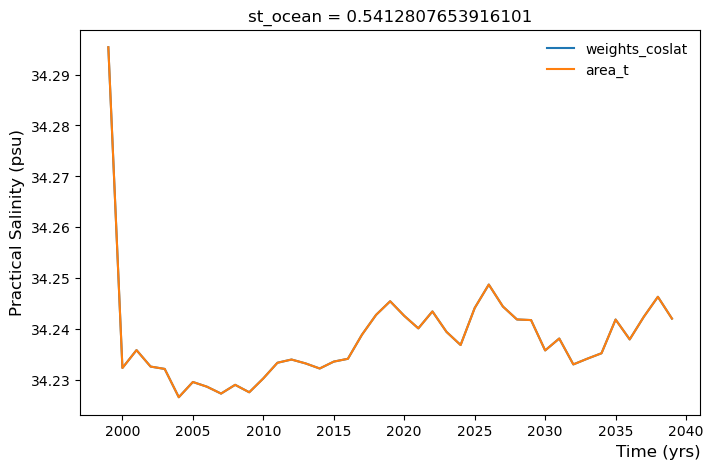

In [28]:
salt_surface_shelf_Mertz = salt_shelf_Mertz.sel(st_ocean=0, method='nearest').weighted(weights)
salt_surface_shelf_Mertz_weighted_area_t = salt_shelf_Mertz.sel(st_ocean=0, method='nearest').weighted(area_t.fillna(0))

fig = plt.figure(figsize=(8, 5))
salt_surface_shelf_Mertz.mean(("xt_ocean","yt_ocean")).plot(label='weights_coslat')
salt_surface_shelf_Mertz_weighted_area_t.mean(("xt_ocean","yt_ocean")).plot(label='area_t')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

## Weighted averages over area

this line is wrong:

weights_st = salt.st_ocean

The reason is that st_ocean describes the vertical position of the cell centre, not the thickness of each cell. Now it *might* be that xarray is smart enough to figure this out, but I doubt it. Best way to figure this out is as we discussed, set up a simple example for which you know the answer. Write a very short piece of code to test the use of st_ocean. My suspicion is that if you go through this exercise then you will discover that you need to use a cell thickness variable. The absolutely gold standard for doing this is to use dzt, which is a 3-D field of cell thickness. But a good approximation is to load:

st_edges_ocean = cc.querying.getvar(expt='01deg_jra55v140_iaf_KvJ09', variable='st_edges_ocean', session=session, frequency='1 monthly', n=1)

which gives the edges of each of the cell, then take

thickness = np.diff(st_edges_ocean)

and make a dataarray of weights from thickess. Again, don’t take my word for it — test this and make sure you can prove to yourself that this is the right method. This will leave you confident in your code and you can go ahead and compute these averages with no doubt in the result.

In [40]:
st_edges_ocean = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='st_edges_ocean', 
                          session=session, frequency='1 monthly',
                          start_time='1999-12-31 00:00:00', 
                          end_time='2039-12-31 00:00:00')

thickness = np.diff(st_edges_ocean)
thickness = xr.DataArray(thickness)

# Weighted average salt with all depths
salt_thickness = salt.weighted(thickness).mean('st_ocean')

In [56]:
salt_thickness_shelf = salt_thickness*shelf_mask
salt_thickness_shelf_weighted = salt_thickness_shelf.weighted(weights)

salt_thickness_shelf_Mertz_weighted = salt_shelf_Mertz.weighted(thickness).mean('st_ocean')
salt_thickness_shelf_Mertz = salt_thickness_shelf_Mertz_weighted.weighted(weights)

In [54]:
salt_thickness_shelf_Mertz_mean = salt_thickness_shelf_Mertz.mean(("xt_ocean","yt_ocean"))
salt_thickness_shelf_Mertz_mean

<xarray.DataArray (year: 41, dim_0: 75)>
dask.array<truediv, shape=(41, 75), dtype=float64, chunksize=(1, 75), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1999 2000 2001 2002 2003 ... 2035 2036 2037 2038 2039
Dimensions without coordinates: dim_0

In [58]:
salt_st_shelf_Mertz_weighted

<xarray.DataArray (year: 41, yt_ocean: 95, xt_ocean: 250)>
dask.array<truediv, shape=(41, 95, 250), dtype=float64, chunksize=(1, 82, 250), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -224.9 -224.8 -224.7 ... -200.2 -200.1 -200.0
  * yt_ocean  (yt_ocean) float64 -68.99 -68.94 -68.9 ... -65.1 -65.06 -65.02
  * year      (year) int64 1999 2000 2001 2002 2003 ... 2035 2036 2037 2038 2039
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 250), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(95, 250), meta=np.ndarray>

In [55]:
salt_st_shelf_Mertz_mean = salt_st_shelf_Mertz.mean(("xt_ocean","yt_ocean"))
salt_st_shelf_Mertz_mean

<xarray.DataArray (year: 41)>
dask.array<truediv, shape=(41,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * year     (year) int64 1999 2000 2001 2002 2003 ... 2035 2036 2037 2038 2039

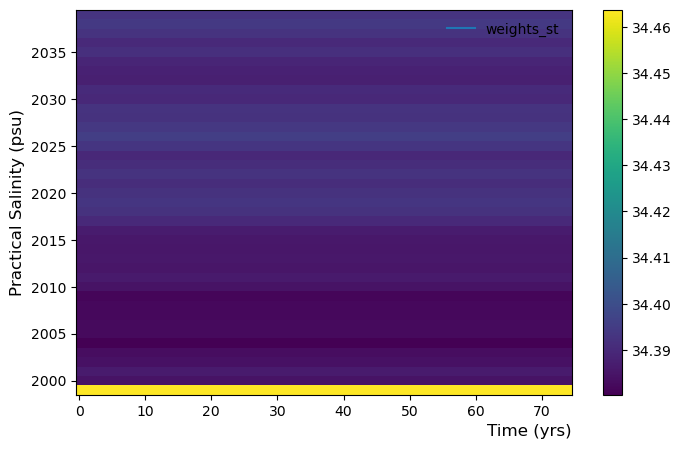

In [51]:
fig = plt.figure(figsize=(8, 5))
salt_st_shelf_Mertz.mean(("xt_ocean","yt_ocean")).plot(label='weights_st')
salt_thickness_shelf_Mertz.mean(("xt_ocean","yt_ocean")).plot(label='weights_thickness')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

In [44]:
salt_thickness_shelf_Mertz

DataArrayWeighted with weights along dimensions: yt_ocean, xt_ocean

In [45]:
salt_st_shelf_Mertz

DataArrayWeighted with weights along dimensions: yt_ocean

In [46]:
salt_surface_shelf_Mertz_weighted_area_t

DataArrayWeighted with weights along dimensions: yt_ocean, xt_ocean

In [50]:
fig = plt.figure(figsize=(8, 5))
salt_st_shelf_Mertz.mean(("xt_ocean","yt_ocean")).sel(time=slice('1999-12-31 00:00:00','2000-12-31 00:00:00')).plot(label='weights_st')
salt_thickness_shelf_Mertz.mean(("xt_ocean","yt_ocean")).sel(time=slice('1999-12-31 00:00:00','2000-12-31 00:00:00')).plot(label='weights_thickness')
plt.xlabel('Time (yrs)', fontsize=12, loc='right')
plt.ylabel('Practical Salinity (psu)', fontsize=12)
plt.legend(loc='upper right', frameon=False, fontsize=10)

ValueError: dimensions or multi-index levels ['time'] do not exist

<Figure size 800x500 with 0 Axes>